In [32]:
import torch
device= torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("USING device :",device)
print(torch.cuda.get_device_name(0))

USING device : cuda
NVIDIA A100-SXM4-80GB


# Configuration

In [33]:
import numpy as np
import os
# from sklearn.preprocessing import LabelEncoder
import cv2

In [71]:
data_path = r"../datasets/terra_incognita"
num_domains = 4
num_classes = 10
all_domains = ["location_38", "location_43", "location_46", "location_100"]
all_classes = ["bird", "bobcat", "cat", "coyote", "dog", "empty", "opossum", "rabbit", "raccoon", "squirrel"]

train_dom_idx = [0,1,2]
eval_dom_idx = [3]
train_class_idx = list(range(8))
eval_class_idx = [9,10]
train_domains = all_domains[:3]
eval_domains = all_domains[3:]
train_classes = all_classes[:8]
eval_classes = all_classes[8:]

len(train_classes)

8

# Definitions

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from PIL import Image

In [36]:
# ---------------- Custom Dataset with Data Augmentation ----------------
# Assuming training_images and testing_images are NumPy arrays with shape (N, 128, 128, 3)
# and training_labels and testing_labels are NumPy arrays with integer labels.
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images: NumPy array of shape (N, 128, 128, 3)
        labels: NumPy array of shape (N,)
        transform: torchvision transforms to be applied on each image
        """
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # Convert the NumPy image (H, W, C) to a PIL Image for transforms
        image = Image.fromarray((image * 255).astype(np.uint8))  # if images are in [0,1]
        if self.transform:
            image = self.transform(image)
        return image, label


In [37]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # (32, 128, 128)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # (32, 64, 64)
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),   # (64, 64, 64)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),         # (64, 32, 32)
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # (128, 32, 32)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)          # (128, 16, 16)
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        # Flatten the feature maps: alternative to x = x.view(x.size(0), -1)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x


# Training Data Preparation

In [38]:
def image_reader(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (128, 128))
    img = img / 255.0
    return img

In [39]:
def numpi_shuffler(images, labels):
    images_np = np.array(images)
    encoded_labels_np = np.array(labels)

    # Create a random permutation of indices and shuffle arrays
    indices = np.random.permutation(len(images_np))
    shuffled_images = images_np[indices]
    shuffled_labels = encoded_labels_np[indices]

    return shuffled_images, shuffled_labels

In [40]:
# ---------------- Define Transforms ----------------
# Training transform with data augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # Rotate by up to 10 degrees
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),  # Random crop and resize back to 128x128
    transforms.ToTensor(),
    # If you used normalization during training, add it here.
    # e.g., transforms.Normalize(mean=[...], std=[...])
])

# Testing transform: only resize and convert to tensor
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [41]:
dTrain_images = []
cTrain_images = {dom:[] for dom in train_domains}
dFamiliar_images = []
cFamiliar_images = {dom:[] for dom in train_domains}
dTrain_label = []
cTrain_label = {dom:[] for dom in train_domains}
dFamiliar_label = []
cFamiliar_label = {dom:[] for dom in train_domains}

for d in range(len(train_domains)):
    domain = train_domains[d]
    for c in range(len(train_classes)):
        classcount = 0
        clas = train_classes[c]
        directory_path = os.path.join(data_path, domain, clas)
        for file_name in os.listdir(directory_path):
            if classcount>50:
                break
            else:
                classcount+=1
            file_path = os.path.join(directory_path, file_name)
            if np.random.uniform(0.0, 1.0) < 0.8:
                dTrain_images.append(image_reader(file_path))
                dTrain_label.append(d)
                cTrain_images[domain].append(image_reader(file_path))
                cTrain_label[domain].append(c)
            else:
                dFamiliar_images.append(image_reader(file_path))
                dFamiliar_label.append(d)
                cFamiliar_images[domain].append(image_reader(file_path))
                cFamiliar_label[domain].append(c)

dLabel_mapping = {i:train_domains[i] for i in range(len(train_domains))}
cLabel_mapping = {i:train_classes[i] for i in range(len(train_classes))}

In [42]:
dTrain_images, dTrain_label = numpi_shuffler(dTrain_images, dTrain_label)
dFamiliar_images, dFamiliar_label = numpi_shuffler(dFamiliar_images, dFamiliar_label)
for dom in train_domains:
    cTrain_images[dom], cTrain_label[dom] = numpi_shuffler(cTrain_images[dom], cTrain_label[dom])
    cFamiliar_images[dom], cFamiliar_label[dom] = numpi_shuffler(cFamiliar_images[dom], cFamiliar_label[dom])

In [ ]:
# Create custom datasets and Dataloaders
dTrain_dataset = CustomDataset(dTrain_images, dTrain_label, transform=train_transform)
dFamiliar_dataset = CustomDataset(dFamiliar_images, dFamiliar_label, transform=test_transform)
dTrain_loader = DataLoader(dTrain_dataset, batch_size=32, shuffle=True)
dFamiliar_loader  = DataLoader(dFamiliar_dataset, batch_size=32, shuffle=False)

cTrain_datasets = {dom:CustomDataset(cTrain_images[dom], cTrain_label[dom], transform=train_transform) for dom in train_domains}
cFamiliar_datasets = {dom:CustomDataset(cFamiliar_images[dom], cFamiliar_label[dom], transform=train_transform) for dom in train_domains}
cTrain_loaders = {dom:DataLoader(cTrain_datasets[dom], batch_size=32, shuffle=True) for dom in train_domains}
cFamiliar_loaders  = {dom:DataLoader(cFamiliar_datasets[dom], batch_size=32, shuffle=False) for dom in train_domains}

In [ ]:
domain_model = SimpleCNN(num_classes=len(train_domains)).to(device)
class_models = {dom:SimpleCNN(num_classes=len(train_classes)).to(device) for dom in train_domains}

# Model Training

In [44]:
num_epochs = 20
def Trainer(num_epochs, learning_rate, weight_d, model, train_loader, train_dataset):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_d)
    # Optionally, add a learning rate scheduler:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images=images.to(device)
            #labels = torch.tensor(labels)
            labels=labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
        
        epoch_loss = running_loss / len(train_dataset)
        if (epoch+1)%5==0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        
        # Update scheduler if using one
        scheduler.step(epoch_loss)

In [45]:
print("Domain Classifier")
Trainer(20, 0.001, 1e-5, domain_model, dTrain_loader, dTrain_dataset)

Domain Classifier
Epoch [5/20], Loss: 0.2372
Epoch [10/20], Loss: 0.1513
Epoch [15/20], Loss: 0.1144
Epoch [20/20], Loss: 0.0757


In [51]:
for dom in train_domains:
    print(dom+" Classifier")
    Trainer(75, 0.001, 1e-5, class_models[dom], cTrain_loaders[dom], cTrain_datasets[dom])

location_38 Classifier
Epoch [5/75], Loss: 1.6241
Epoch [10/75], Loss: 1.5840
Epoch [15/75], Loss: 1.5070
Epoch [20/75], Loss: 1.4527
Epoch [25/75], Loss: 1.4050
Epoch [30/75], Loss: 1.3644
Epoch [35/75], Loss: 1.2730
Epoch [40/75], Loss: 1.2152
Epoch [45/75], Loss: 1.1786
Epoch 00045: reducing learning rate of group 0 to 5.0000e-04.
Epoch [50/75], Loss: 1.0617
Epoch [55/75], Loss: 1.0251
Epoch [60/75], Loss: 0.9584
Epoch 00061: reducing learning rate of group 0 to 2.5000e-04.
Epoch [65/75], Loss: 0.9046
Epoch [70/75], Loss: 0.8756
Epoch 00074: reducing learning rate of group 0 to 1.2500e-04.
Epoch [75/75], Loss: 0.8767
location_43 Classifier
Epoch [5/75], Loss: 1.6155
Epoch [10/75], Loss: 1.4810
Epoch [15/75], Loss: 1.3967
Epoch [20/75], Loss: 1.3006
Epoch [25/75], Loss: 1.2949
Epoch [30/75], Loss: 1.2485
Epoch [35/75], Loss: 1.1534
Epoch 00037: reducing learning rate of group 0 to 5.0000e-04.
Epoch [40/75], Loss: 1.0476
Epoch [45/75], Loss: 0.9788
Epoch [50/75], Loss: 1.0036
Epoch 00

# **MODEL EVALUATION**

1. CLASSIFICATION REPORT USING SEG_TEST
2. CONFUSION MATRIX

In [52]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import torch.nn.functional as F

In [53]:
def entropy(cls_prob):
    score = -torch.sum(cls_prob * torch.log(cls_prob.clamp(min=1e-12)), dim=1)
    return score

In [54]:
def ModelChecker(model, test_loader, class_names):
    model.eval()
    all_preds=[]
    all_labels=[]
    all_certs=[]
    all_uncerts=[]

    with torch.no_grad():
        for images,labels in test_loader:
            images=images.to(device)
            labels= labels.to(device)
            outputs= model(images)
            probs = F.softmax(outputs, dim=1)
            certs,preds = torch.max(probs,1)
            all_certs.extend(certs.cpu().numpy())
            #_,preds=torch.max(outputs,1)
            uncerts = entropy(probs)
            all_uncerts.extend(uncerts.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds=np.array(all_preds)
    all_labels=np.array(all_labels)
    all_certs=np.array(all_certs)
    all_uncerts=np.array(all_uncerts)

    report= classification_report(all_labels,all_preds,target_names=class_names)
    print("classification report:\n",report)

    conf_matrix= confusion_matrix(all_labels,all_preds)
    # print("Confusion Matrix:\n",conf_matrix)

    correct_mask = all_preds == all_labels
    incorrect_mask = ~correct_mask

    # -------------------------------
    # Set up the figure
    # -------------------------------
    fig = plt.figure(figsize=(16, 12))
    grid = GridSpec(3, 2, height_ratios=[1.2, 1, 1])

    ax0 = fig.add_subplot(grid[0, :])
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    disp.plot(ax=ax0, cmap='Blues', values_format='d', colorbar=False)
    ax0.set_title('Confusion Matrix')

    ax1 = fig.add_subplot(grid[1, 0])
    sns.histplot(all_certs[correct_mask], bins=30, kde=True, color='green', ax=ax1)
    ax1.set_title('Certainty — Correct Predictions')
    ax1.set_xlabel('Certainty')
    ax1.set_ylabel('Count')

    ax2 = fig.add_subplot(grid[1, 1])
    sns.histplot(all_certs[incorrect_mask], bins=30, kde=True, color='red', ax=ax2)
    ax2.set_title('Certainty — Incorrect Predictions')
    ax2.set_xlabel('Certainty')
    ax2.set_ylabel('Count')

    ax3 = fig.add_subplot(grid[2, 0])
    sns.histplot(all_uncerts[correct_mask], bins=30, kde=True, color='blue', ax=ax3)
    ax3.set_title('Uncertainty — Correct Predictions')
    ax3.set_xlabel('Uncertainty')
    ax3.set_ylabel('Count')

    ax4 = fig.add_subplot(grid[2, 1])
    sns.histplot(all_uncerts[incorrect_mask], bins=30, kde=True, color='orange', ax=ax4)
    ax4.set_title('Uncertainty — Incorrect Predictions')
    ax4.set_xlabel('Uncertainty')
    ax4.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

classification report:
               precision    recall  f1-score   support

 location_38       1.00      0.99      0.99        71
 location_43       1.00      0.99      0.99        75
 location_46       0.97      1.00      0.99        69

    accuracy                           0.99       215
   macro avg       0.99      0.99      0.99       215
weighted avg       0.99      0.99      0.99       215



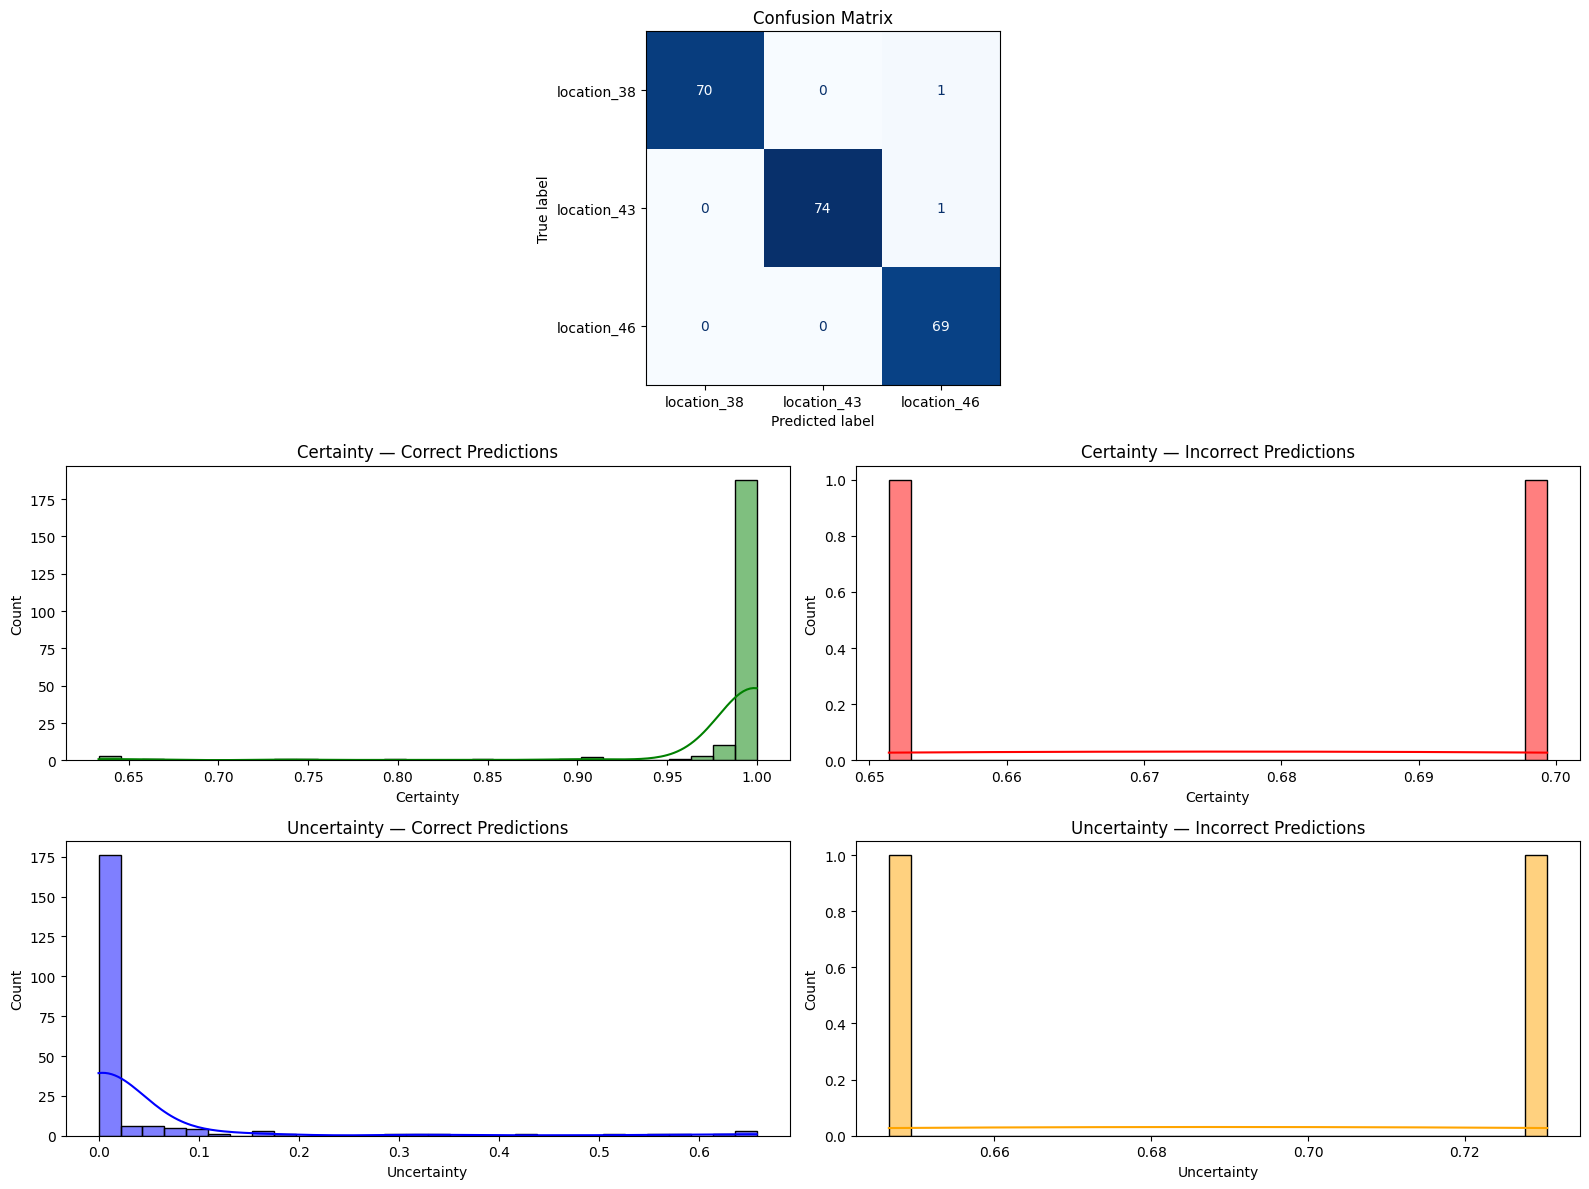

In [55]:
ModelChecker(domain_model, dFamiliar_loader, train_domains)

classification report:
               precision    recall  f1-score   support

        bird       1.00      0.50      0.67         2
      bobcat       0.83      0.83      0.83         6
         cat       0.33      0.20      0.25        10
      coyote       0.69      0.92      0.79        12
         dog       0.44      0.36      0.40        11
       empty       0.25      0.18      0.21        11
     opossum       0.53      1.00      0.70         8
      rabbit       0.40      0.36      0.38        11

    accuracy                           0.52        71
   macro avg       0.56      0.54      0.53        71
weighted avg       0.49      0.52      0.49        71



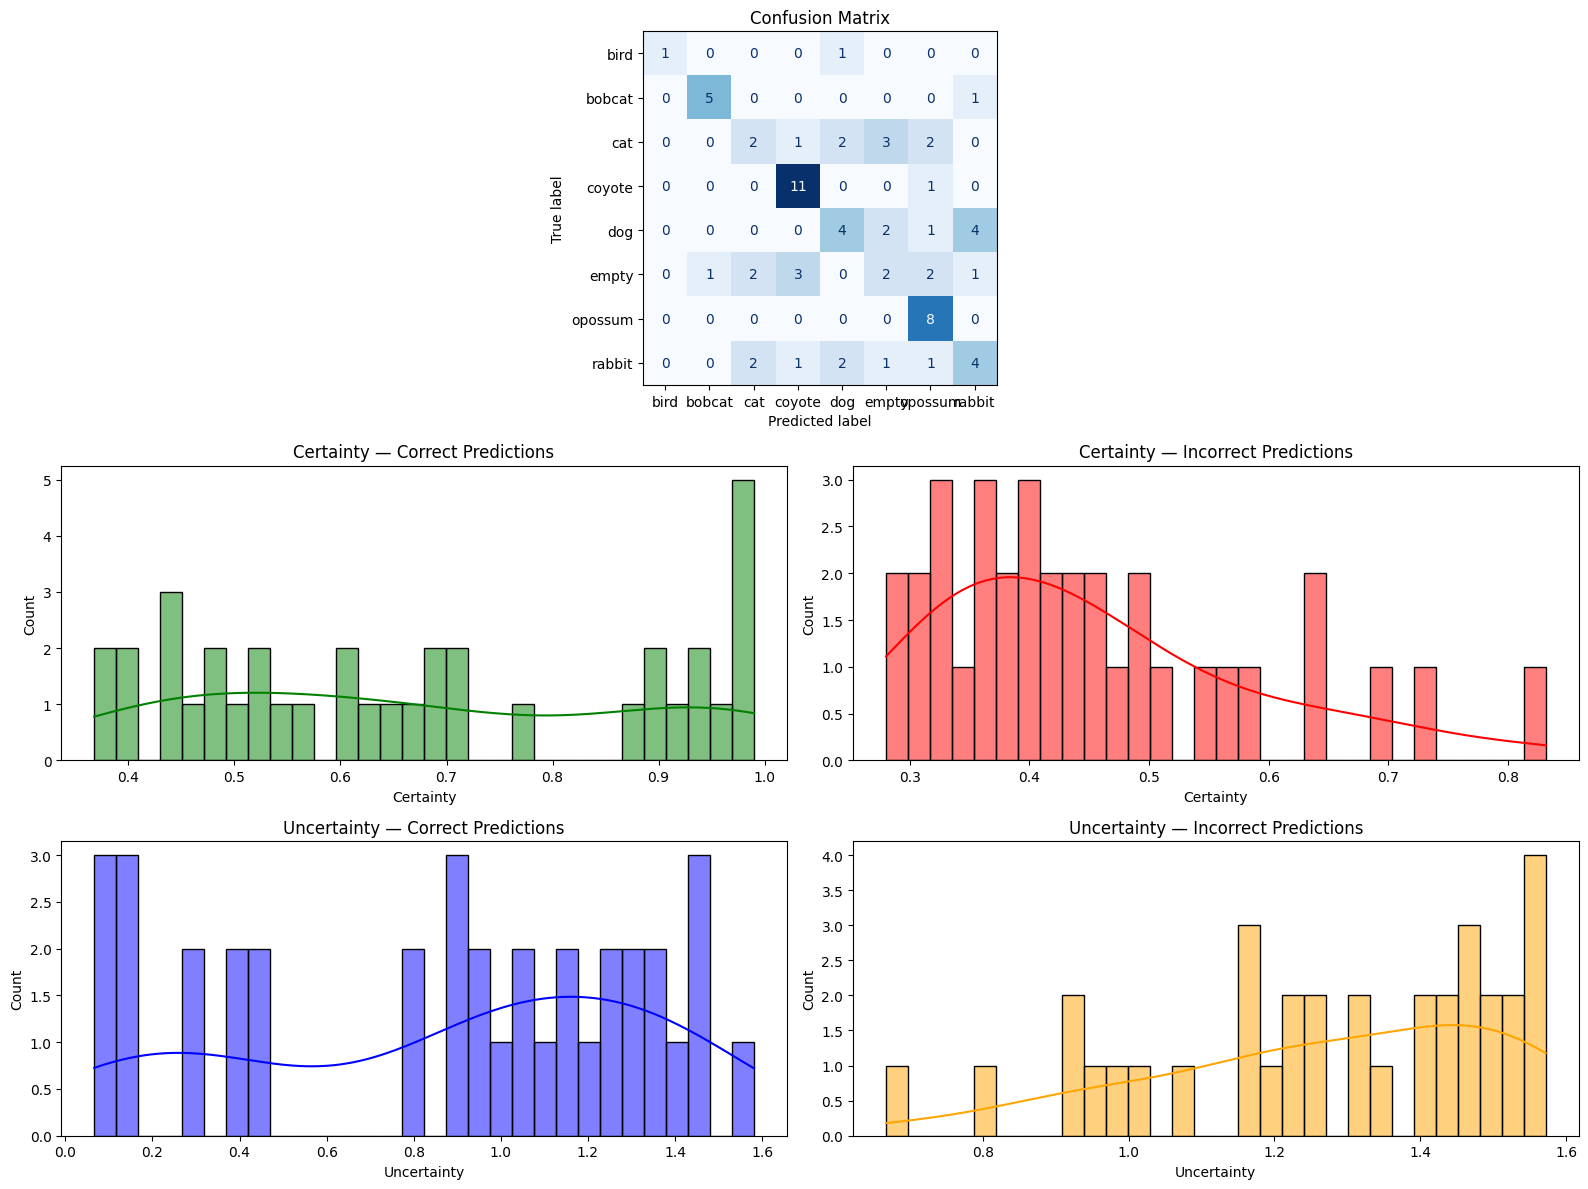

In [56]:
ModelChecker(class_models["location_38"], cFamiliar_loaders["location_38"], train_classes)

classification report:
               precision    recall  f1-score   support

        bird       0.88      0.70      0.78        10
      bobcat       0.25      0.11      0.15         9
         cat       1.00      1.00      1.00         1
      coyote       0.56      0.62      0.59         8
         dog       0.75      1.00      0.86        12
       empty       0.56      0.33      0.42        15
     opossum       0.36      0.80      0.50        10
      rabbit       1.00      0.60      0.75        10

    accuracy                           0.60        75
   macro avg       0.67      0.65      0.63        75
weighted avg       0.63      0.60      0.59        75



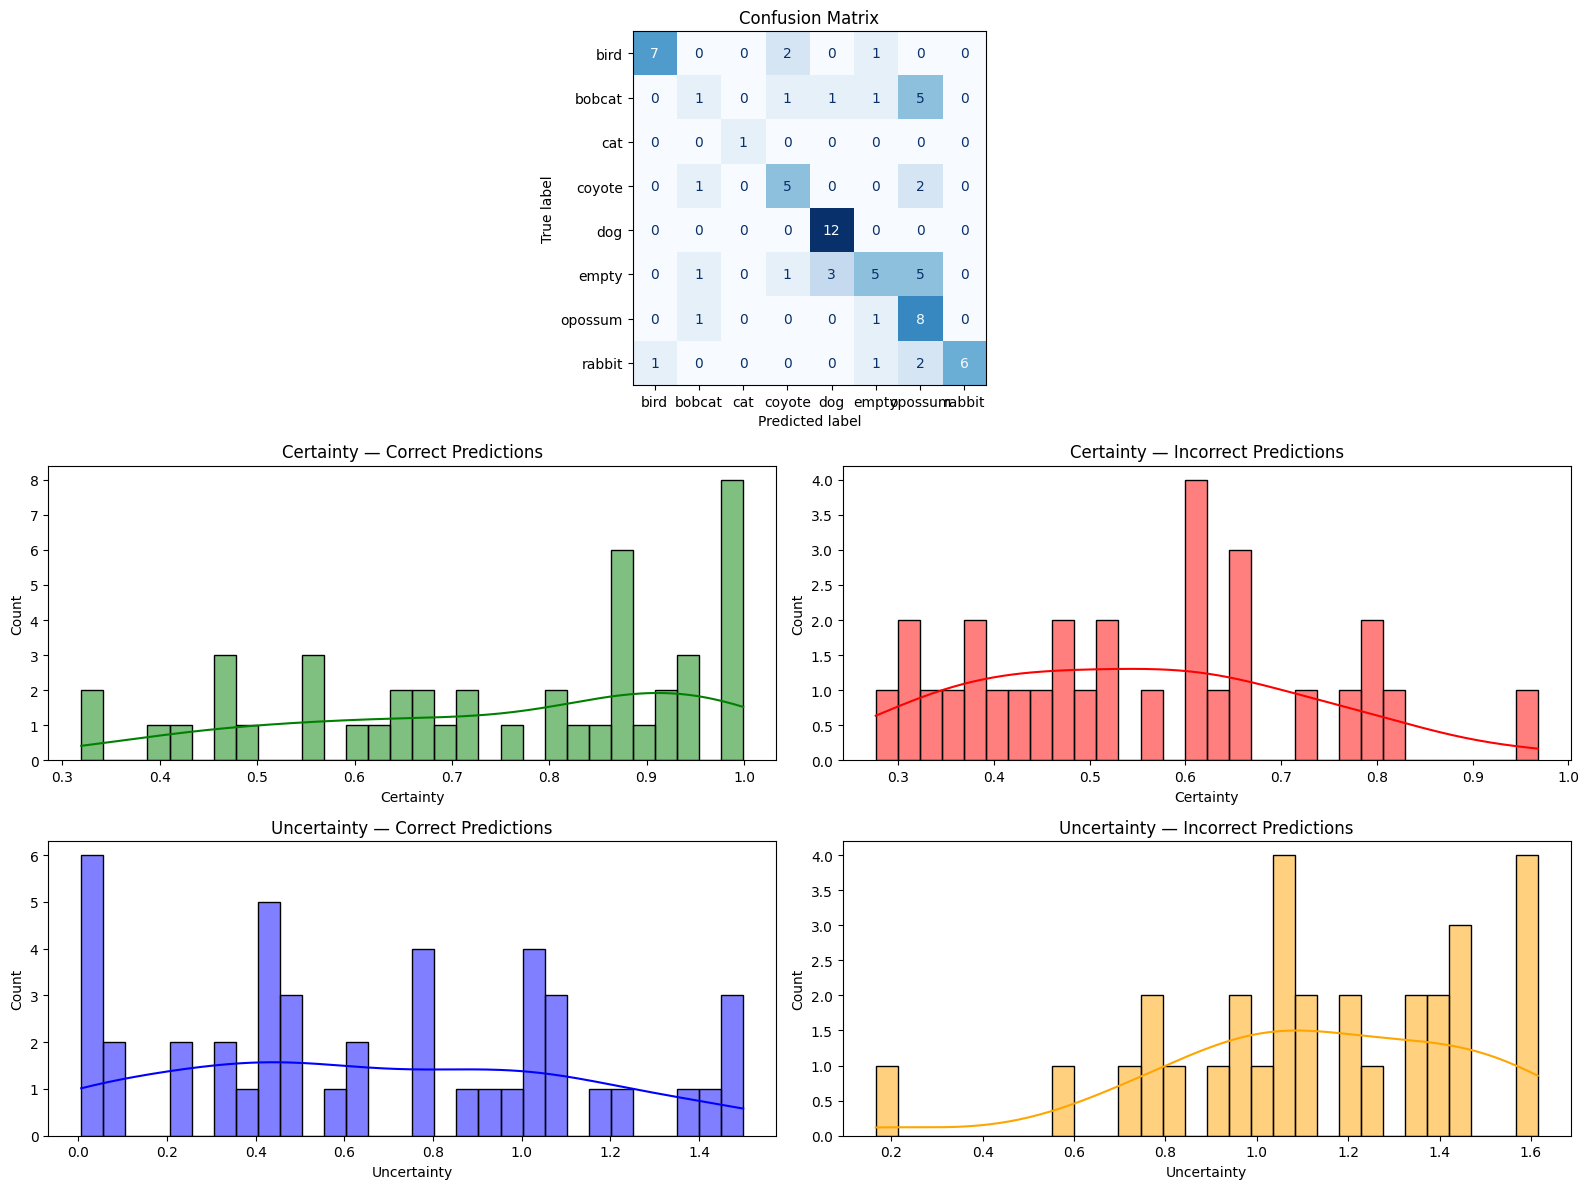

In [57]:
ModelChecker(class_models["location_43"], cFamiliar_loaders["location_43"], train_classes)

classification report:
               precision    recall  f1-score   support

        bird       0.56      0.83      0.67         6
      bobcat       0.36      0.50      0.42         8
         cat       0.80      0.80      0.80         5
      coyote       0.20      0.20      0.20         5
         dog       0.92      1.00      0.96        11
       empty       0.33      0.22      0.27         9
     opossum       0.62      0.71      0.67        14
      rabbit       0.40      0.18      0.25        11

    accuracy                           0.57        69
   macro avg       0.52      0.56      0.53        69
weighted avg       0.54      0.57      0.54        69



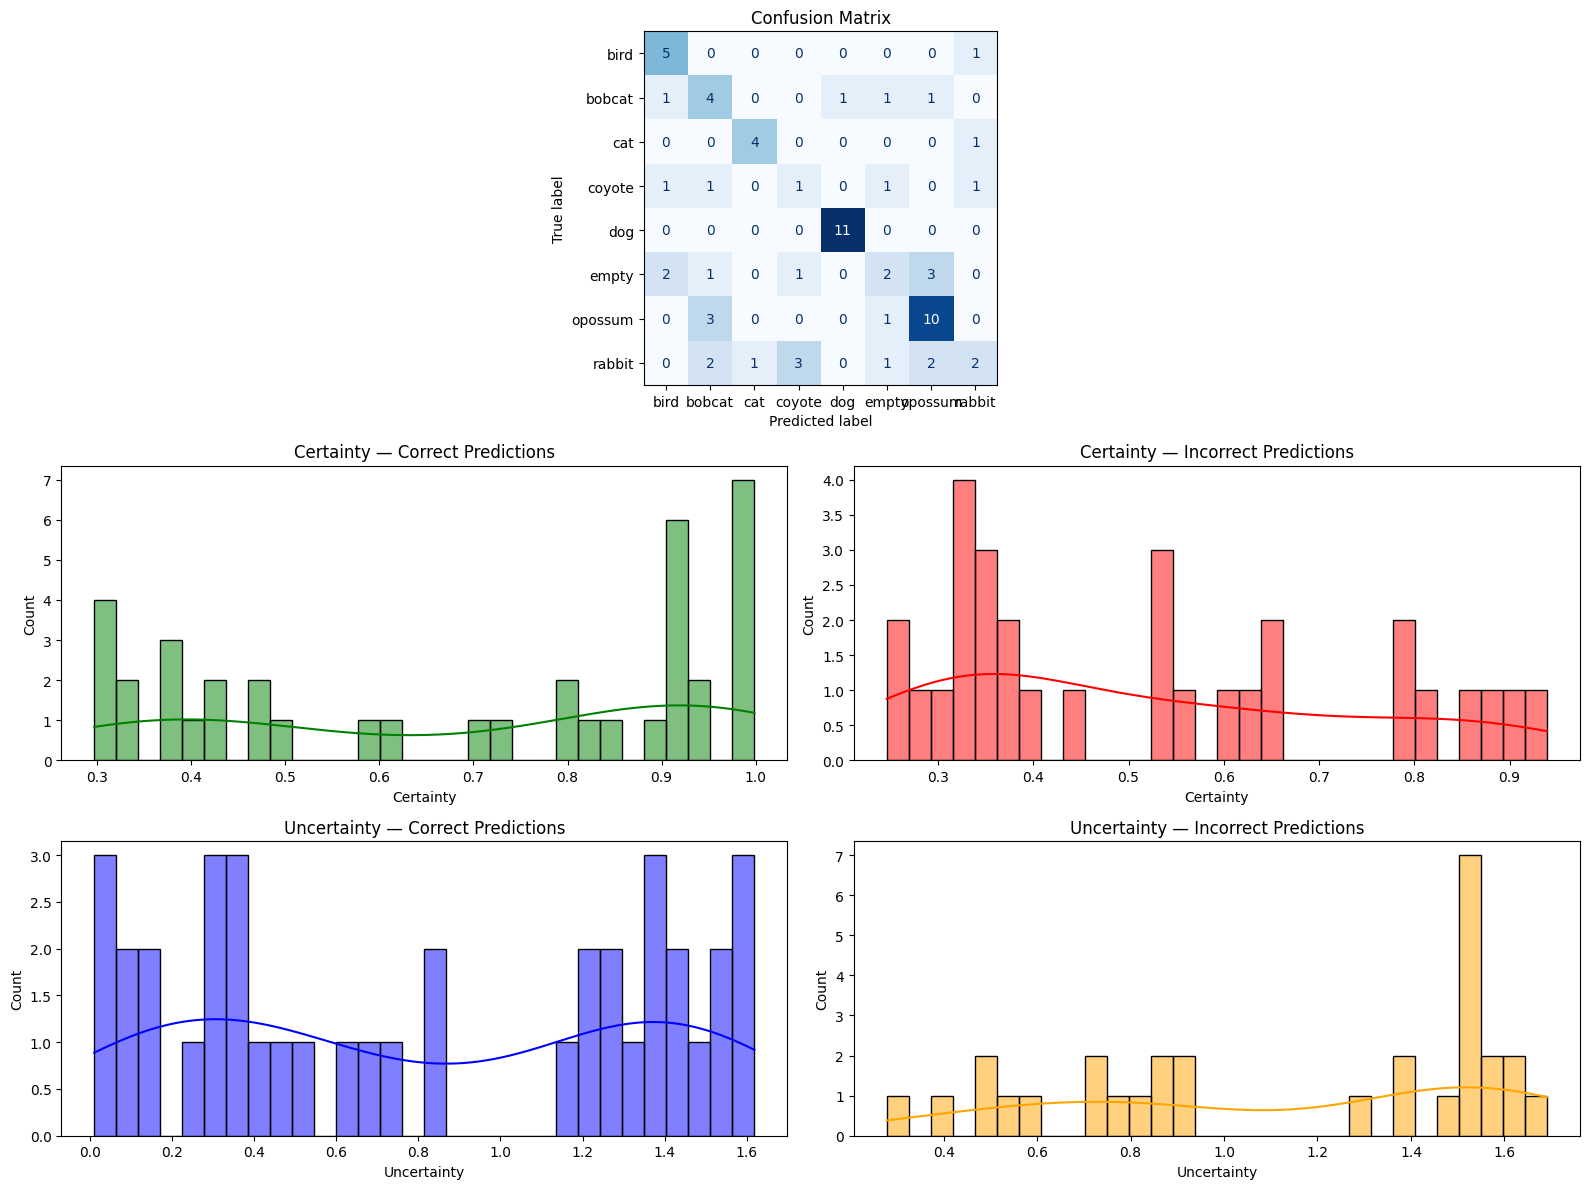

In [58]:
ModelChecker(class_models["location_46"], cFamiliar_loaders["location_46"], train_classes)

In [59]:
def CompleteChecker(domain_model, class_models, test_loader, train_domain_names, class_names):
    domain_model.eval()
    for dom in train_domain_names:
        class_models[dom].eval()

    all_preds=[]
    all_labels=[]
    all_certs=[]
    all_uncerts=[]

    with torch.no_grad():
        for images,labels in test_loader:
            images=images.to(device)
            labels= labels.to(device)

            dom_outputs= domain_model(images)
            dom_probs = F.softmax(dom_outputs, dim=1)

            class_outputs = {}
            class_probs = {}
            for dom in train_domain_names:
                class_outputs[dom] = class_models[dom](images)
                class_probs[dom] = F.softmax(class_outputs[dom], dim=1)
            
            probs = torch.zeros_like(next(iter(class_probs.values())))
            for idx, dom in enumerate(train_domain_names):
                weight = dom_probs[:, idx].unsqueeze(1)
                probs += weight * class_probs[dom]

            certs,preds = torch.max(probs,1)
            uncerts = entropy(probs)

            all_certs.extend(certs.cpu().numpy())
            all_uncerts.extend(uncerts.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds=np.array(all_preds)
    all_labels=np.array(all_labels)
    all_certs=np.array(all_certs)
    all_uncerts=np.array(all_uncerts)

    report= classification_report(all_labels,all_preds,target_names=class_names)
    print("classification report:\n",report)

    conf_matrix= confusion_matrix(all_labels,all_preds)
    #print("Confusion Matrix:\n",conf_matrix)

    correct_mask = all_preds == all_labels
    incorrect_mask = ~correct_mask

    # -------------------------------
    # Set up the figure
    # -------------------------------
    fig = plt.figure(figsize=(16, 12))
    grid = GridSpec(3, 2, height_ratios=[1.2, 1, 1])

    ax0 = fig.add_subplot(grid[0, :])
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    disp.plot(ax=ax0, cmap='Blues', values_format='d', colorbar=False)
    ax0.set_title('Confusion Matrix')

    ax1 = fig.add_subplot(grid[1, 0])
    sns.histplot(all_certs[correct_mask], bins=30, kde=True, color='green', ax=ax1)
    ax1.set_title('Certainty — Correct Predictions')
    ax1.set_xlabel('Certainty')
    ax1.set_ylabel('Count')

    ax2 = fig.add_subplot(grid[1, 1])
    sns.histplot(all_certs[incorrect_mask], bins=30, kde=True, color='red', ax=ax2)
    ax2.set_title('Certainty — Incorrect Predictions')
    ax2.set_xlabel('Certainty')
    ax2.set_ylabel('Count')

    ax3 = fig.add_subplot(grid[2, 0])
    sns.histplot(all_uncerts[correct_mask], bins=30, kde=True, color='blue', ax=ax3)
    ax3.set_title('Uncertainty — Correct Predictions')
    ax3.set_xlabel('Uncertainty')
    ax3.set_ylabel('Count')

    ax4 = fig.add_subplot(grid[2, 1])
    sns.histplot(all_uncerts[incorrect_mask], bins=30, kde=True, color='orange', ax=ax4)
    ax4.set_title('Uncertainty — Incorrect Predictions')
    ax4.set_xlabel('Uncertainty')
    ax4.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

/raid/infolab/bhavyakohli/miniconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/raid/infolab/bhavyakohli/miniconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/raid/infolab/bhavyakohli/miniconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

classification report:
               precision    recall  f1-score   support

        bird       0.00      0.00      0.00         2
      bobcat       0.86      1.00      0.92         6
         cat       0.33      0.20      0.25        10
      coyote       0.73      0.92      0.81        12
         dog       0.50      0.36      0.42        11
       empty       0.33      0.18      0.24        11
     opossum       0.47      1.00      0.64         8
      rabbit       0.50      0.55      0.52        11

    accuracy                           0.55        71
   macro avg       0.47      0.53      0.48        71
weighted avg       0.50      0.55      0.51        71



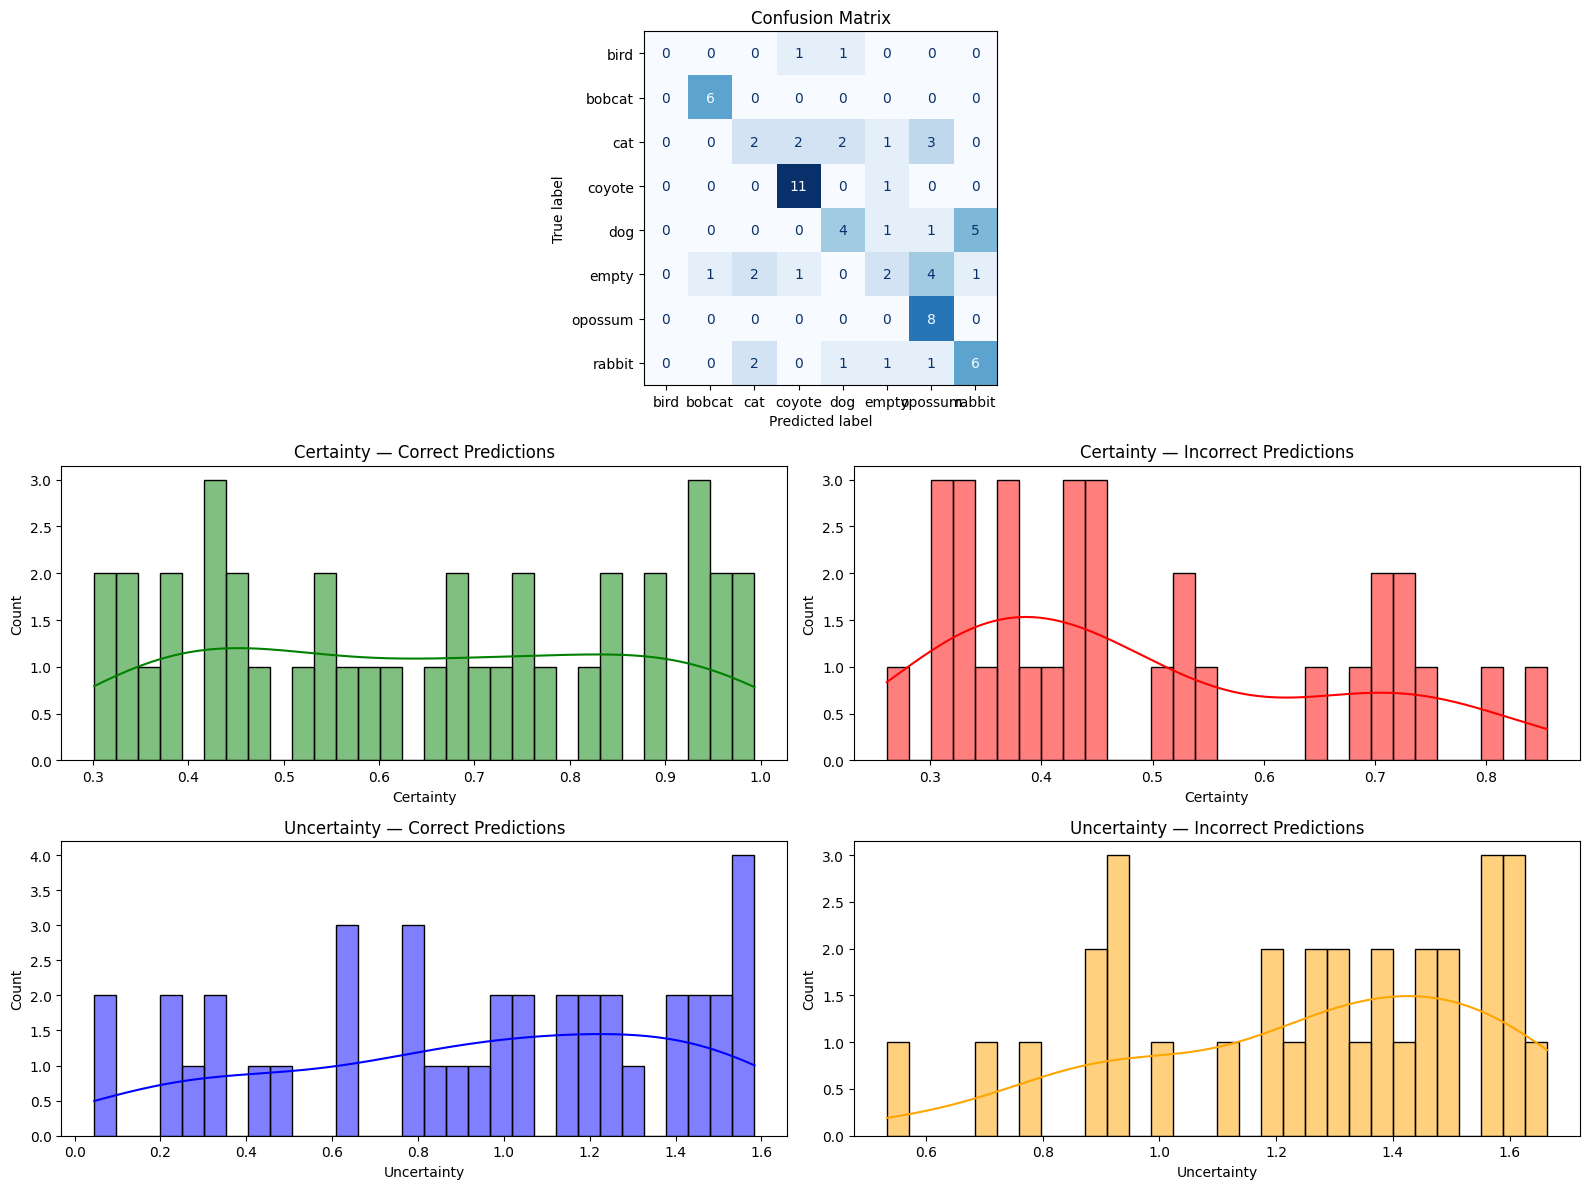

In [60]:
CompleteChecker(domain_model, class_models, cFamiliar_loaders["location_38"], train_domains, train_classes)

classification report:
               precision    recall  f1-score   support

        bird       0.86      0.60      0.71        10
      bobcat       0.17      0.11      0.13         9
         cat       0.50      1.00      0.67         1
      coyote       0.57      0.50      0.53         8
         dog       0.71      1.00      0.83        12
       empty       0.56      0.33      0.42        15
     opossum       0.35      0.70      0.47        10
      rabbit       0.86      0.60      0.71        10

    accuracy                           0.56        75
   macro avg       0.57      0.61      0.56        75
weighted avg       0.59      0.56      0.55        75



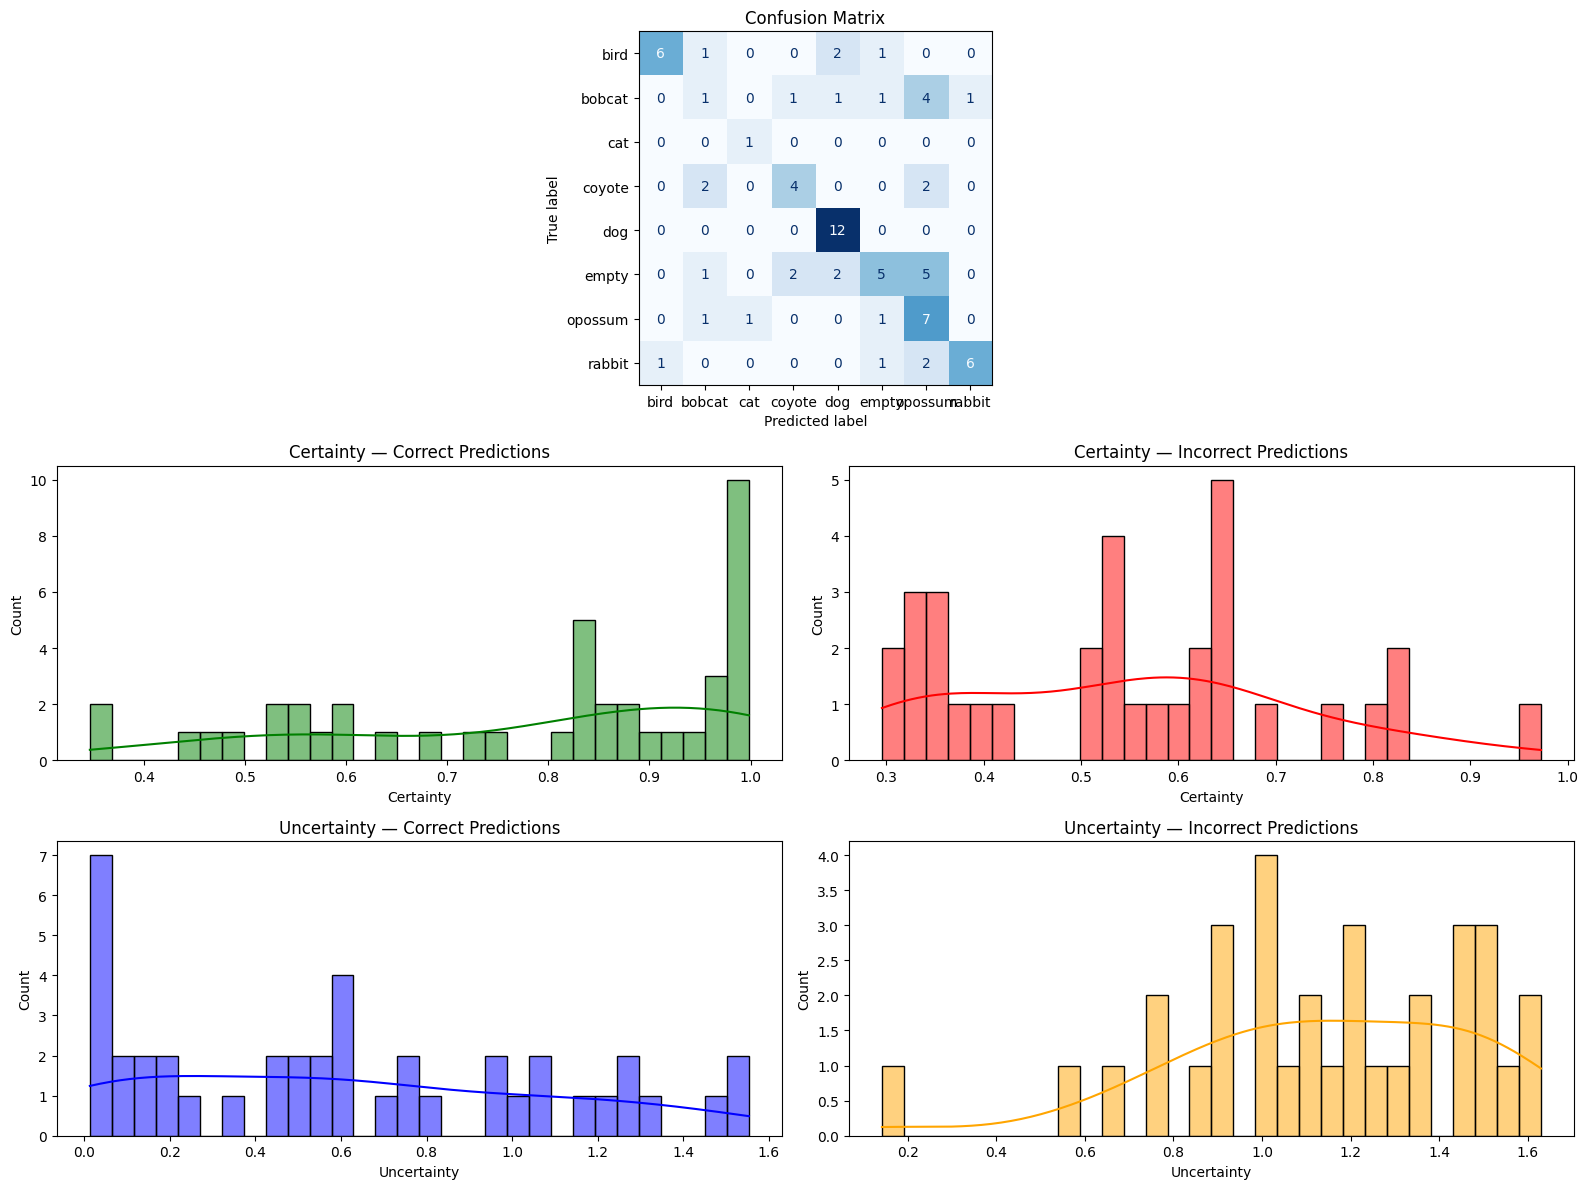

In [61]:
CompleteChecker(domain_model, class_models, cFamiliar_loaders["location_43"], train_domains, train_classes)

classification report:
               precision    recall  f1-score   support

        bird       0.45      0.83      0.59         6
      bobcat       0.25      0.38      0.30         8
         cat       0.50      0.40      0.44         5
      coyote       0.20      0.20      0.20         5
         dog       0.92      1.00      0.96        11
       empty       0.25      0.11      0.15         9
     opossum       0.67      0.71      0.69        14
      rabbit       0.33      0.18      0.24        11

    accuracy                           0.51        69
   macro avg       0.45      0.48      0.45        69
weighted avg       0.49      0.51      0.48        69



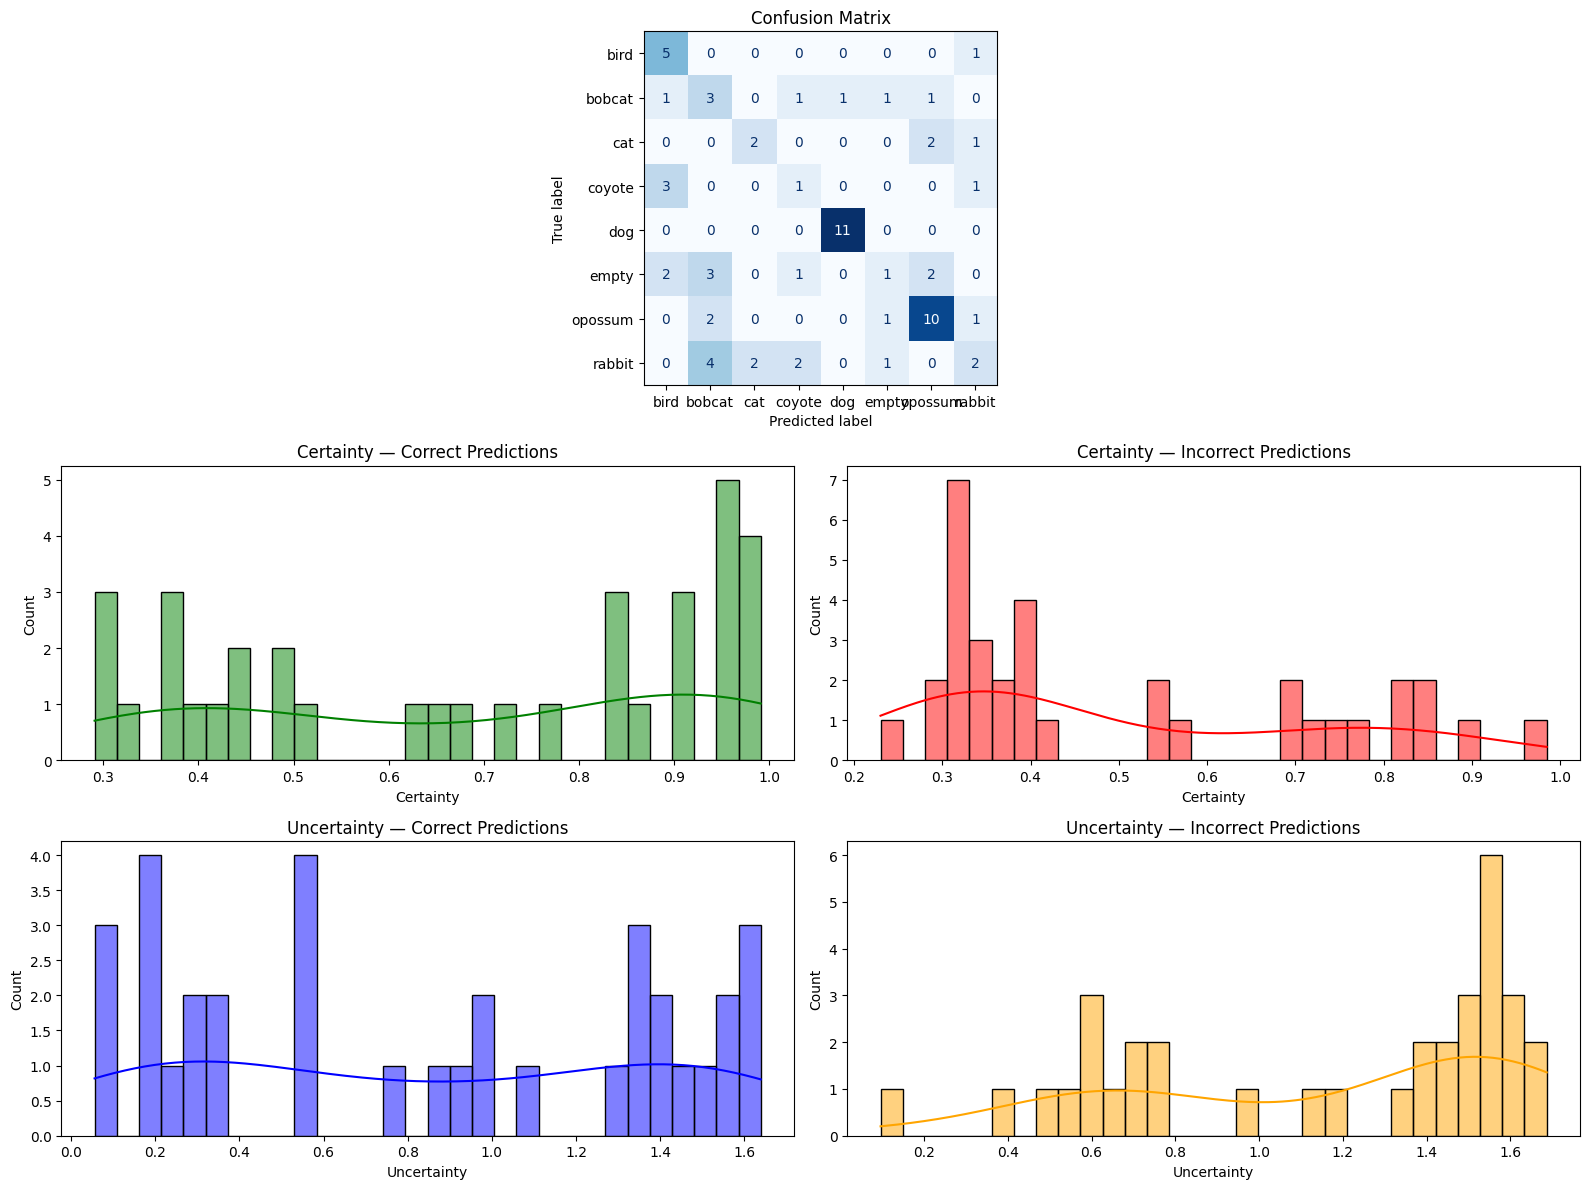

In [62]:
CompleteChecker(domain_model, class_models, cFamiliar_loaders["location_46"], train_domains, train_classes)

# Testing Data Preparation

In [72]:
test_images = []
test_labels = []
unseen_images = []
unseen_labels = []

for d in range(len(eval_domains)):
    domain = eval_domains[d]
    for c in range(len(train_classes)):
        classcount = 0
        clas = train_classes[c]
        directory_path = os.path.join(data_path, domain, clas)
        for file_name in os.listdir(directory_path):
            if classcount>50:
                break
            else:
                classcount += 1
            file_path = os.path.join(directory_path, file_name)
            test_images.append(image_reader(file_path))
            test_labels.append(c)
    for c in range(len(eval_classes)):
        clascount = 0
        clas = eval_classes[c]
        directory_path = os.path.join(data_path, domain, clas)
        for file_name in os.listdir(directory_path):
            if clascount>50:
                break
            else:
                clascount += 1
            file_path = os.path.join(directory_path, file_name)
            unseen_images.append(image_reader(file_path))
            unseen_labels.append(c)

In [73]:
test_images = np.array(test_images)
test_labels = np.array(test_labels)
unseen_images = np.array(unseen_images)
unseen_labels = np.array(unseen_labels)

# Create custom datasets and Dataloaders
test_dataset = CustomDataset(test_images, test_labels, transform=test_transform)
unseen_dataset = CustomDataset(unseen_images, unseen_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
unseen_loader  = DataLoader(unseen_dataset, batch_size=32, shuffle=False)

# Model Testing

classification report:
               precision    recall  f1-score   support

        bird       0.49      0.45      0.47        51
      bobcat       0.00      0.00      0.00        51
         cat       0.00      0.00      0.00        51
      coyote       0.00      0.00      0.00        12
         dog       1.00      0.06      0.11        51
       empty       0.17      0.24      0.20        51
     opossum       0.35      0.84      0.50        51
      rabbit       0.20      0.41      0.27        51

    accuracy                           0.28       369
   macro avg       0.28      0.25      0.19       369
weighted avg       0.31      0.28      0.21       369



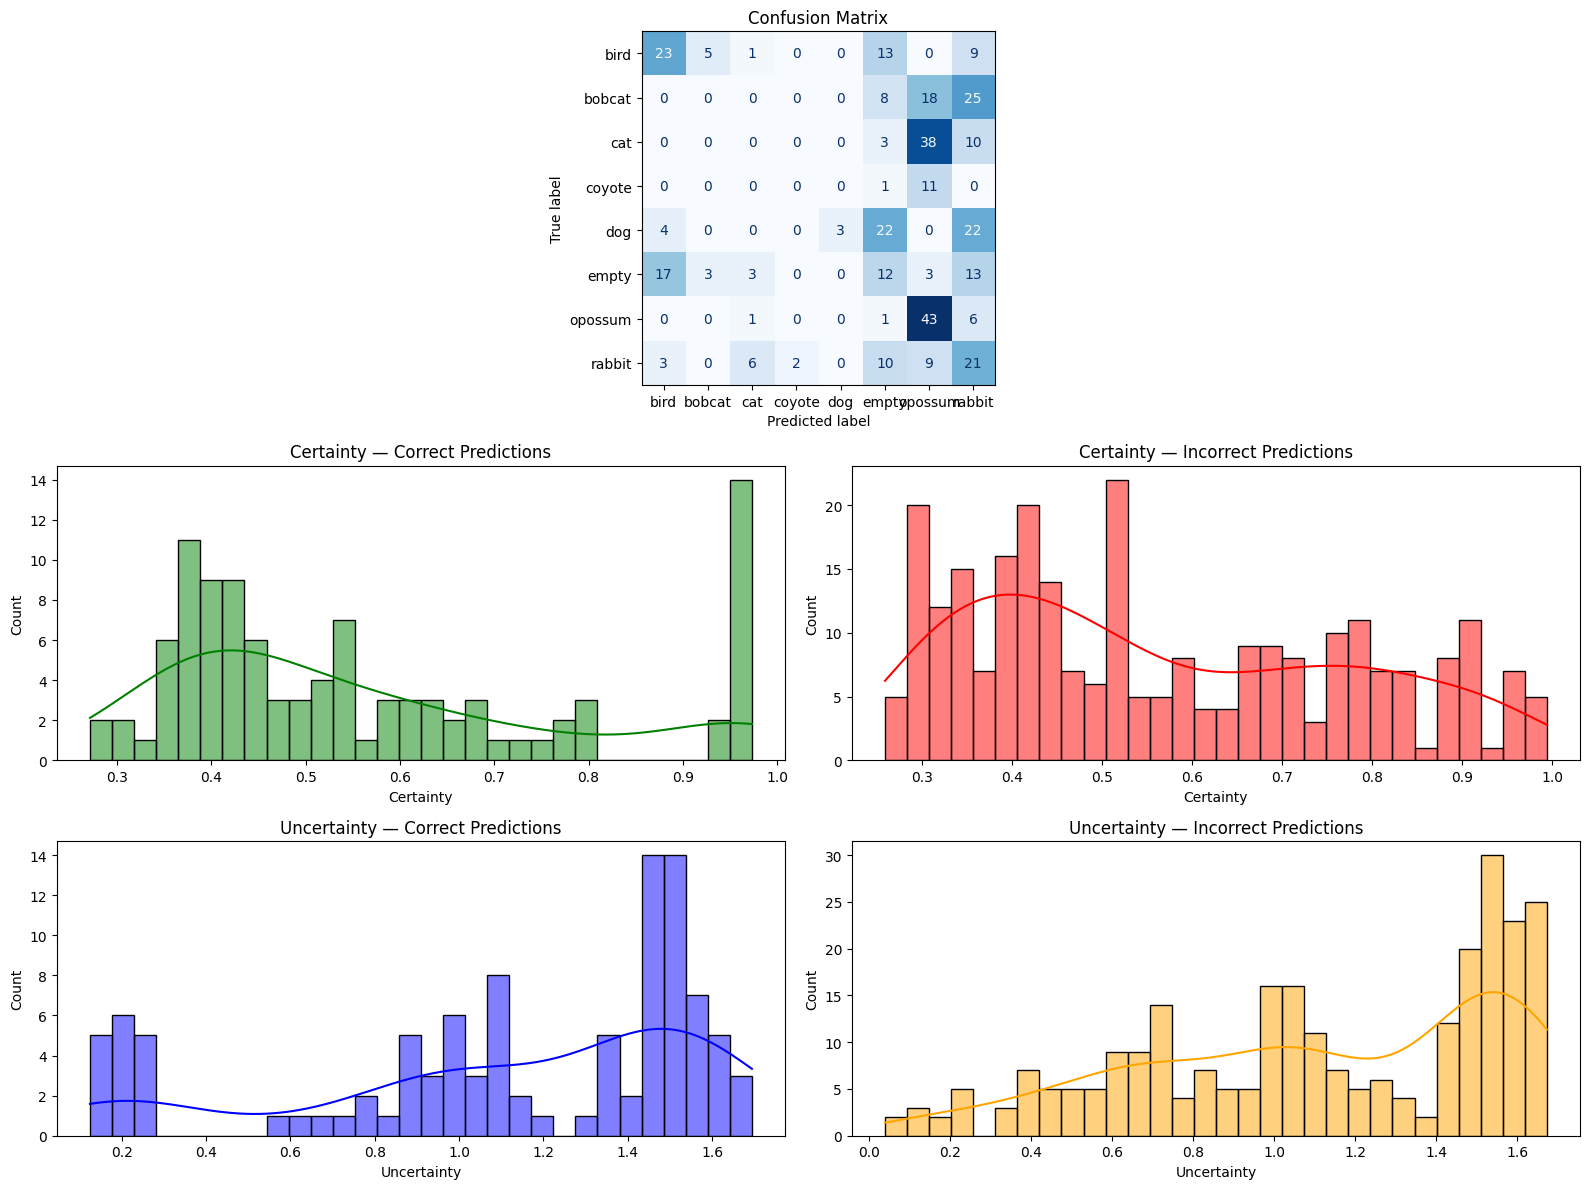

In [74]:
CompleteChecker(domain_model, class_models, test_loader, train_domains, train_classes)

/raid/infolab/bhavyakohli/miniconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/raid/infolab/bhavyakohli/miniconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/raid/infolab/bhavyakohli/miniconda3/envs/work/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

classification report:
               precision    recall  f1-score   support

        bird       0.00      0.00      0.00        51
      bobcat       0.43      0.41      0.42        51
         cat       0.31      0.69      0.43        51
      coyote       0.00      0.00      0.00        12
         dog       1.00      0.06      0.11        51
       empty       0.21      0.59      0.31        51
     opossum       0.21      0.12      0.15        51
      rabbit       0.13      0.08      0.10        51

    accuracy                           0.27       369
   macro avg       0.29      0.24      0.19       369
weighted avg       0.32      0.27      0.21       369



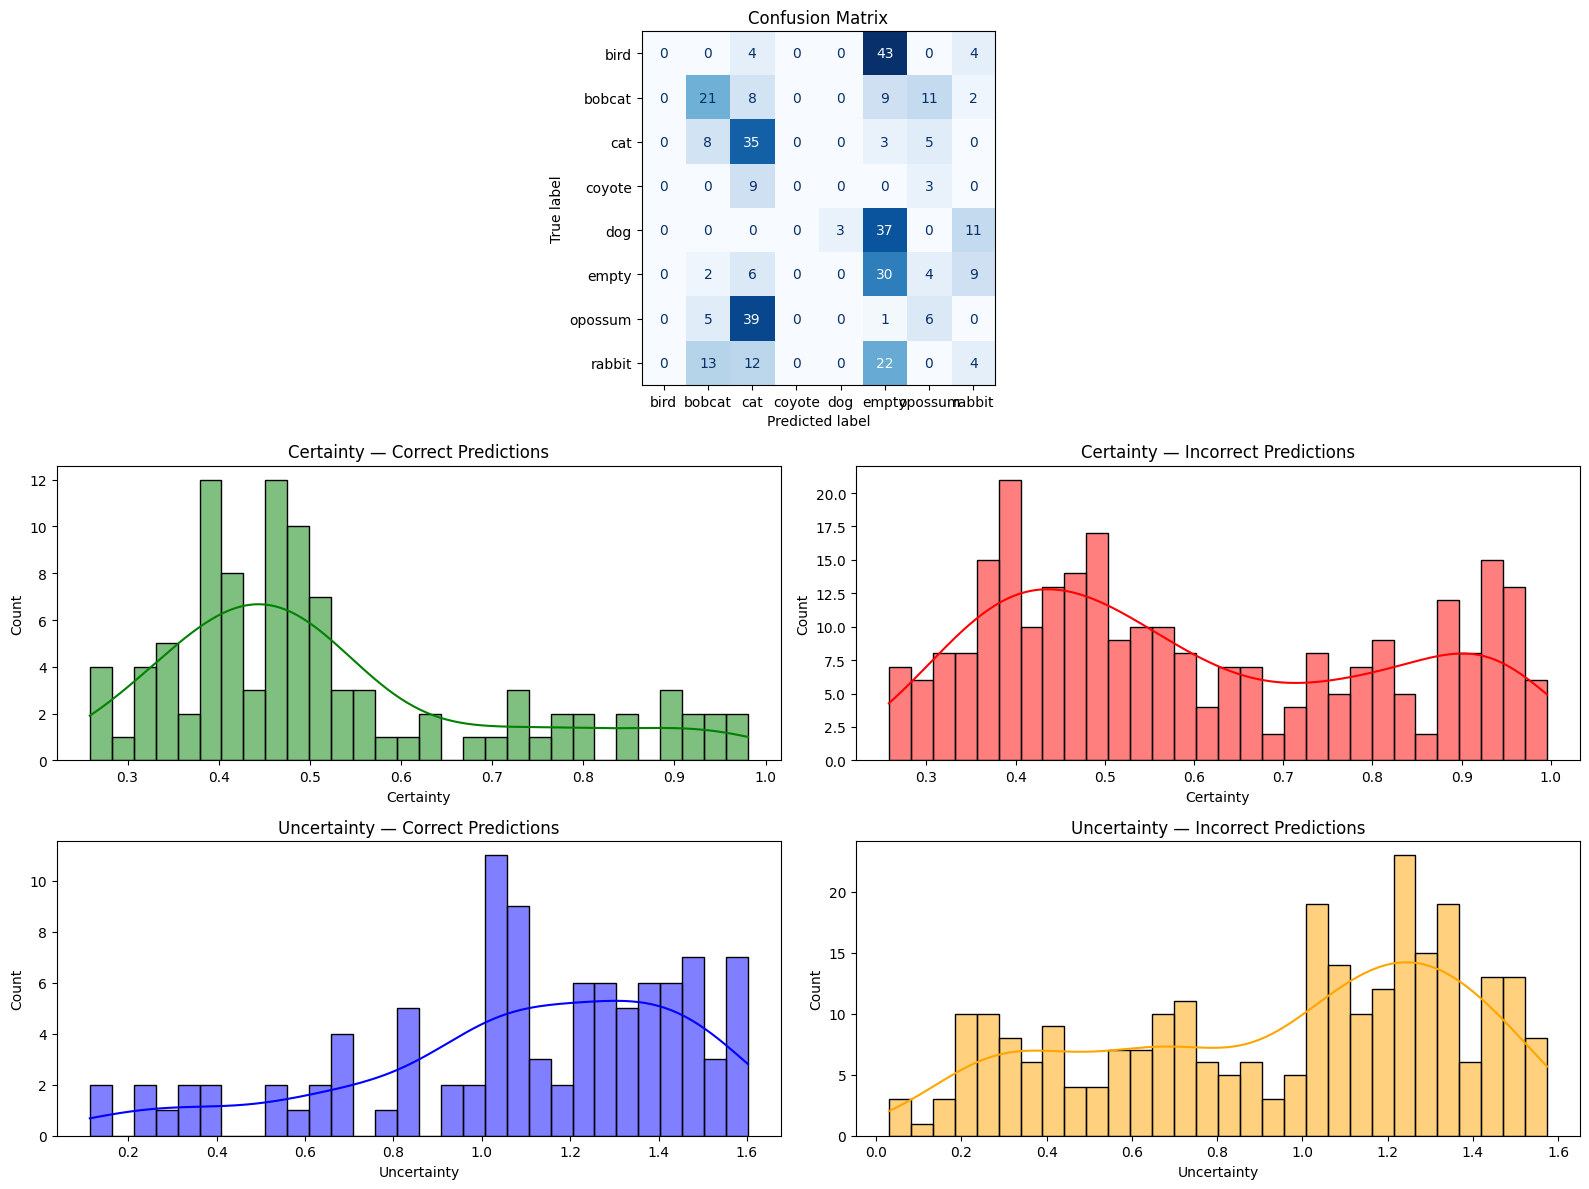

In [78]:
ModelChecker(class_models["location_38"], test_loader, train_classes)

# Unseen Testing

In [75]:
def UnseenChecker(domain_model, class_models, test_loader, train_domain_names):
    domain_model.eval()
    for dom in train_domain_names:
        class_models[dom].eval()

    all_preds=[]
    all_certs=[]
    all_uncerts=[]

    with torch.no_grad():
        for images,_ in test_loader:
            images=images.to(device)

            dom_outputs= domain_model(images)
            dom_probs = F.softmax(dom_outputs, dim=1)

            class_outputs = {}
            class_probs = {}
            for dom in train_domain_names:
                class_outputs[dom] = class_models[dom](images)
                class_probs[dom] = F.softmax(class_outputs[dom], dim=1)
            
            probs = torch.zeros_like(next(iter(class_probs.values())))
            for idx, dom in enumerate(train_domain_names):
                weight = dom_probs[:, idx].unsqueeze(1)
                probs += weight * class_probs[dom]

            certs,preds = torch.max(probs,1)
            uncerts = entropy(probs)

            all_certs.extend(certs.cpu().numpy())
            all_uncerts.extend(uncerts.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    all_preds=np.array(all_preds)
    all_certs=np.array(all_certs)
    all_uncerts=np.array(all_uncerts)

    # -------------------------------
    # Set up the figure
    # -------------------------------
    fig = plt.figure(figsize=(16, 12))
    grid = GridSpec(3, 2, height_ratios=[1.2, 1, 1])


    ax1 = fig.add_subplot(grid[1, 0])
    sns.histplot(all_certs, bins=30, kde=True, color='green', ax=ax1)
    ax1.set_title('Certainty')
    ax1.set_xlabel('Certainty')
    ax1.set_ylabel('Count')

    ax3 = fig.add_subplot(grid[2, 0])
    sns.histplot(all_uncerts, bins=30, kde=True, color='blue', ax=ax3)
    ax3.set_title('Uncertainty')
    ax3.set_xlabel('Uncertainty')
    ax3.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

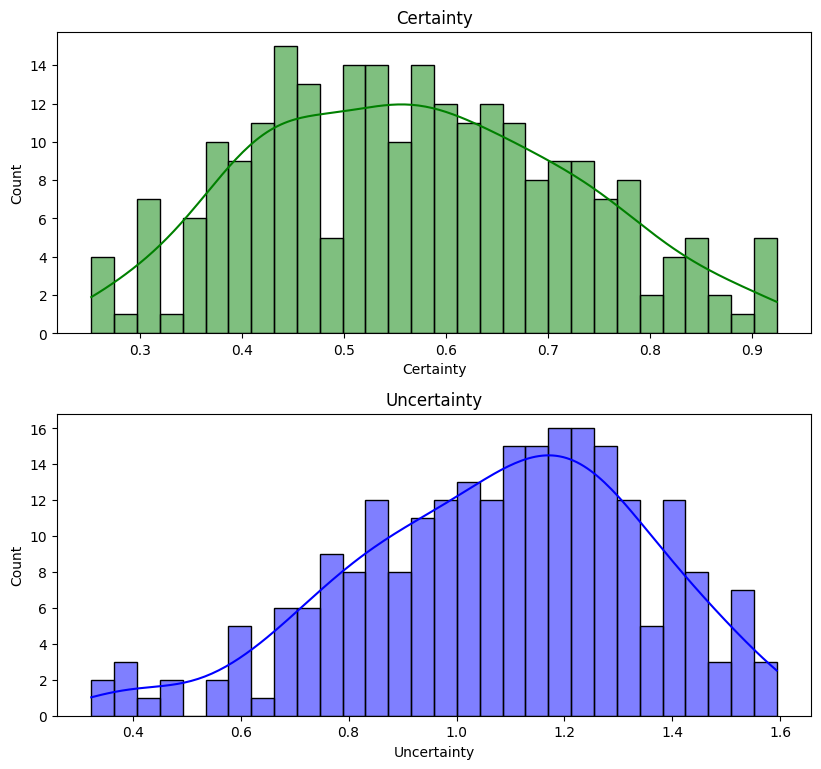

In [31]:
UnseenChecker(domain_model, class_models, unseen_loader, train_domains)

# extras

In [ ]:
# image_paths = []
# image_labels = []
# for d in range(len(eval_domains)):
#     domain = eval_domains[d]
#     for c in range(len(train_classes)):
#         clas = train_classes[c]
#         directory_path = os.path.join(data_path, domain, clas)
#         for file_name in os.listdir(directory_path):
#             file_path = os.path.join(directory_path, file_name)
#             image_paths.append(file_path)
#             image_labels.append(c)

In [ ]:
# pred_path = "../datasets/office31/webcam/bike/frame_0001.jpg"

In [ ]:
# # Move model and image tensor to the device (GPU if available)
# def CompleteEvaluator(img_paths, labels, domain_model=domain_model, class_models=class_models, domain_labels=train_domains, class_labels=train_classes):
#     domain_model.to(device)
#     domain_model.eval()
    

#     for dom in domain_labels:
#         class_models[dom].to(device)
#         class_models[dom].eval()

#     for i in range(len(img_paths)):
#         img = Image.open(img_paths[i]).convert("RGB")

#         transform = transforms.Compose([
#             transforms.Resize((128, 128)),  # Resize to 128x128
#             transforms.ToTensor(),          
#         ])

#         img_tensor = transform(img).unsqueeze(0)
#         img_tensor = img_tensor.to(device)

#         # Evaluate the model on the image
#         with torch.no_grad():
#             preds = []
#             certs = []
#             uncerts = []
#             #AttributeError: 'CustomDataset' object has no attribute 'size'
#             dom_output = domain_model(img_tensor)
#             dom_probs = F.softmax(dom_output, dim=1)
#             j = 0
#             dom = domain_labels[j]
#             class_output = class_models[dom](img_tensor)
#             class_probs = F.softmax(class_output, dim=1)
#             actual_probs = dom_probs[0][j] * class_probs
#             for j in range(1, len(dom_probs[0])):
#                 dom = domain_labels[j]
#                 class_output = class_models[dom](img_tensor)
#                 class_probs = F.softmax(class_output, dim=1)
#                 actual_probs += dom_probs[0][j] * class_probs
#             uncert = entropy(actual_probs)
#             cert, pred = torch.max(actual_probs, dim=1)
#             uncerts.append(uncert)
#             certs.append(cert)
#             preds.append(pred)

#     preds = torch.cat(preds, dim=0).cpu().numpy()
#     certs = torch.cat(certs, dim=0).cpu().numpy()
#     uncerts = torch.tensor(uncerts).cpu().numpy()

#     correct_mask = preds == labels
#     incorrect_mask = ~correct_mask

#     # -------------------------------
#     # Set up the figure
#     # -------------------------------
#     fig = plt.figure(figsize=(16, 12))
#     grid = GridSpec(3, 2, height_ratios=[1.2, 1, 1])


#     ax1 = fig.add_subplot(grid[1, 0])
#     sns.histplot(certs[correct_mask], bins=30, kde=True, color='green', ax=ax1)
#     ax1.set_title('Certainty — Correct Predictions')
#     ax1.set_xlabel('Certainty')
#     ax1.set_ylabel('Count')

#     ax2 = fig.add_subplot(grid[1, 1])
#     sns.histplot(certs[incorrect_mask], bins=30, kde=True, color='red', ax=ax2)
#     ax2.set_title('Certainty — Incorrect Predictions')
#     ax2.set_xlabel('Certainty')
#     ax2.set_ylabel('Count')

#     ax3 = fig.add_subplot(grid[2, 0])
#     sns.histplot(uncerts[correct_mask], bins=30, kde=True, color='blue', ax=ax3)
#     ax3.set_title('Uncertainty — Correct Predictions')
#     ax3.set_xlabel('Uncertainty')
#     ax3.set_ylabel('Count')

#     ax4 = fig.add_subplot(grid[2, 1])
#     sns.histplot(uncerts[incorrect_mask], bins=30, kde=True, color='orange', ax=ax4)
#     ax4.set_title('Uncertainty — Incorrect Predictions')
#     ax4.set_xlabel('Uncertainty')
#     ax4.set_ylabel('Count')

#     plt.tight_layout()
#     plt.show()
#     return 

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 751

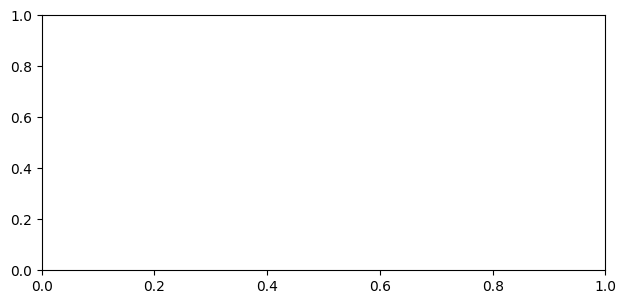

In [ ]:
# CompleteEvaluator(image_paths, image_labels)

In [ ]:
# # Move model and image tensor to the device (GPU if available)
# def Evaluator(model, img_path, labels):
#     img = Image.open(img_path).convert("RGB")

#     transform = transforms.Compose([
#         transforms.Resize((128, 128)),  # Resize to 128x128
#         transforms.ToTensor(),          
#     ])

#     img_tensor = transform(img).unsqueeze(0)
#     model.to(device)
#     img_tensor = img_tensor.to(device)

#     # Evaluate the model on the image
#     model.eval()
#     with torch.no_grad():
#         #AttributeError: 'CustomDataset' object has no attribute 'size'
#         output = model(img_tensor)
#         print(type(output), output)
#         probs = F.softmax(output, dim=1)
#         print(probs)
#         _, predicted = torch.max(output, dim=1)

#     predicted_label = predicted.item()
#     print(predicted_label, labels[predicted_label])
#     return 

In [ ]:
# # Move model and image tensor to the device (GPU if available)
# def CompleteEvaluator(domain_model, class_models, img_tensor, train_domains, train_classes):
#     domain_model.to(device)
#     img_tensor = img_tensor.to(device)

#     # Evaluate the domain model on the image
#     domain_model.eval()
#     with torch.no_grad():
#         #AttributeError: 'CustomDataset' object has no attribute 'size'
#         domain_logits = domain_model(img_tensor)
#         print(type(output), output)
#         _, predicted = torch.max(output, 1)

#     predicted_label = predicted.item()
#     print(predicted_label, labels[predicted_label])

In [ ]:
# Evaluator(domain_model, pred_path, train_domains)

<class 'torch.Tensor'> tensor([[ 1.0424, -1.1186]], device='cuda:0')
tensor([[0.8967, 0.1033]], device='cuda:0')
0 amazon


In [ ]:
# abc = torch.tensor([[ 1.0424, -1.1186]])
# cdef = torch.tensor([[ 1.0424, -1.1186]])
# abc[0][1]*cdef

tensor([[-1.1660,  1.2513]])

In [ ]:
# Evaluator(class_models["amazon"], img_tensor, train_classes)

<class 'torch.Tensor'> tensor([[-1.6326, -2.8096, -1.0975, -2.1476, -0.9902, -3.5406, -5.9390,  0.2154,
         -0.2974, -0.2006, -1.3874, -2.7867, -2.8676, -1.9978, -2.6757, -3.6056,
         -0.0799, -0.5774, -0.4301, -0.5248,  0.1537, -3.4979, -4.4339,  1.0425,
         -0.9316, -1.7128, -0.6711, -0.7449, -2.5976]], device='cuda:0')
tensor([[1.5129e-02, 4.6628e-03, 2.5836e-02, 9.0398e-03, 2.8764e-02, 2.2450e-03,
         2.0398e-04, 9.6029e-02, 5.7506e-02, 6.3351e-02, 1.9333e-02, 4.7711e-03,
         4.4003e-03, 1.0501e-02, 5.3311e-03, 2.1036e-03, 7.1475e-02, 4.3462e-02,
         5.0361e-02, 4.5809e-02, 9.0283e-02, 2.3429e-03, 9.1883e-04, 2.1958e-01,
         3.0498e-02, 1.3965e-02, 3.9574e-02, 3.6757e-02, 5.7643e-03]],
       device='cuda:0')
23 punchers


In [38]:
Evaluator(class_models["dslr"], img_tensor, train_classes)

<class 'torch.Tensor'> tensor([[ 0.4455,  5.0423, -3.3687,  0.4425, -5.1732, -2.7109,  4.9851, -2.2462,
         -0.7672,  3.9686, -1.5845, -0.6298, -0.7301, -1.5858, -2.7337, -3.6440,
         -0.3399, -2.1625, -2.1451, -0.9787, -1.1209,  0.2564, -1.6166, -0.8977,
         -2.3688, -3.3043,  0.4179,  1.2234,  0.3381]], device='cuda:0')
tensor([[4.2280e-03, 4.1931e-01, 9.3249e-05, 4.2156e-03, 1.5345e-05, 1.8003e-04,
         3.9597e-01, 2.8652e-04, 1.2575e-03, 1.4328e-01, 5.5527e-04, 1.4426e-03,
         1.3049e-03, 5.5457e-04, 1.7597e-04, 7.0807e-05, 1.9277e-03, 3.1153e-04,
         3.1700e-04, 1.0177e-03, 8.8281e-04, 3.4997e-03, 5.3777e-04, 1.1036e-03,
         2.5347e-04, 9.9458e-05, 4.1128e-03, 9.2040e-03, 3.7976e-03]],
       device='cuda:0')
1 bike


In [2]:
import numpy as np

In [3]:
dom_logits = [0.0017, 0.1803]
dom_probs = [0.4555, 0.5445]

amazon_logits = np.array([-1.6326, -2.8096, -1.0975, -2.1476, -0.9902, -3.5406, -5.9390,  0.2154,
         -0.2974, -0.2006, -1.3874, -2.7867, -2.8676, -1.9978, -2.6757, -3.6056,
         -0.0799, -0.5774, -0.4301, -0.5248,  0.1537, -3.4979, -4.4339,  1.0425,
         -0.9316, -1.7128, -0.6711, -0.7449, -2.5976])
amazon_probs = np.array([1.5129e-02, 4.6628e-03, 2.5836e-02, 9.0398e-03, 2.8764e-02, 2.2450e-03,
         2.0398e-04, 9.6029e-02, 5.7506e-02, 6.3351e-02, 1.9333e-02, 4.7711e-03,
         4.4003e-03, 1.0501e-02, 5.3311e-03, 2.1036e-03, 7.1475e-02, 4.3462e-02,
         5.0361e-02, 4.5809e-02, 9.0283e-02, 2.3429e-03, 9.1883e-04, 2.1958e-01,
         3.0498e-02, 1.3965e-02, 3.9574e-02, 3.6757e-02, 5.7643e-03])

dslr_logits = np.array([ 0.4455,  5.0423, -3.3687,  0.4425, -5.1732, -2.7109,  4.9851, -2.2462,
         -0.7672,  3.9686, -1.5845, -0.6298, -0.7301, -1.5858, -2.7337, -3.6440,
         -0.3399, -2.1625, -2.1451, -0.9787, -1.1209,  0.2564, -1.6166, -0.8977,
         -2.3688, -3.3043,  0.4179,  1.2234,  0.3381])
dslr_probs = np.array([4.2280e-03, 4.1931e-01, 9.3249e-05, 4.2156e-03, 1.5345e-05, 1.8003e-04,
         3.9597e-01, 2.8652e-04, 1.2575e-03, 1.4328e-01, 5.5527e-04, 1.4426e-03,
         1.3049e-03, 5.5457e-04, 1.7597e-04, 7.0807e-05, 1.9277e-03, 3.1153e-04,
         3.1700e-04, 1.0177e-03, 8.8281e-04, 3.4997e-03, 5.3777e-04, 1.1036e-03,
         2.5347e-04, 9.9458e-05, 4.1128e-03, 9.2040e-03, 3.7976e-03])

In [41]:
np.argmax(dslr_logits)

1

In [42]:
np.argmax(0.0017*amazon_logits + 0.1803*dslr_logits)

1

In [5]:
0.4555*amazon_probs + 0.5445*dslr_probs

array([0.00919341, 0.2304382 , 0.01181907, 0.00641302, 0.01311036,
       0.00112062, 0.21569858, 0.04389722, 0.02687869, 0.10687234,
       0.00910853, 0.00295873, 0.00271485, 0.00508517, 0.00252413,
       0.00099674, 0.0336065 , 0.01996657, 0.02311204, 0.02142014,
       0.0416046 , 0.00297278, 0.00071134, 0.1006196 , 0.01402985,
       0.00641521, 0.02026538, 0.02175439, 0.00469343])

In [50]:
np.argmax(0.0017*amazon_logits + 0.1803*dslr_logits)

1

In [9]:
prob_score = torch.tensor([[0.00919341, 0.2304382 , 0.01181907, 0.00641302, 0.01311036,
       0.00112062, 0.21569858, 0.04389722, 0.02687869, 0.10687234,
       0.00910853, 0.00295873, 0.00271485, 0.00508517, 0.00252413,
       0.00099674, 0.0336065 , 0.01996657, 0.02311204, 0.02142014,
       0.0416046 , 0.00297278, 0.00071134, 0.1006196 , 0.01402985,
       0.00641521, 0.02026538, 0.02175439, 0.00469343]])
uncertainty = entropy(prob_score)
uncertainty

tensor([2.4869])

In [10]:
len(prob_score[0])

29

In [11]:
max_uncert = torch.tensor([[1/29,1/29,1/29,1/29,1/29,1/29,1/29,1/29,1/29,1/29,
                            1/29,1/29,1/29,1/29,1/29,1/29,1/29,1/29,1/29,1/29,
                            1/29,1/29,1/29,1/29,1/29,1/29,1/29,1/29,1/29]])
entropy(max_uncert)

tensor([3.3673])

In [12]:
max_cert = torch.tensor([[0,0,0,0,0,0,0,0,0,0,
                          0,0,0,0,0,0,0,0,0,0,
                          0,0,0,0,0,0,0,0,1]])
entropy(max_cert)

tensor([nan])